# Import Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import mean_squared_error, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV
import pickle

In [0]:
# define function to pick model after it is fit
def pickle_model(model_name, model):
    model_pickle_path = './{}.pkl'.format(model_name)
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

# Import Data

In [0]:
# import dataset into pandas and assign to variable
data = pd.read_pickle('dummies_user_df.pkl')

In [4]:
data.shape

(103209, 54)

In [5]:
data.head()

,user_id,likes_count,replies_count,retweets_count,tweet_ss,target,num_hashtags,avg_convo_ss,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_tag_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_depression,search_happiness,search_happy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,autumn,spring,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,PM
0,57,1.666667,0.666667,0.000000,0.450733,0,2.000000,0.450733,0.345007,0.393048,0.336220,0.696395,0.34988,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.666667,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000,0.666667,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0,1.000000
1,59,3.527778,0.694444,0.222222,0.579114,0,2.000000,0.583351,0.347117,0.502371,0.350550,0.709567,0.34988,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.194444,0.083333,0.055556,0.138889,0.166667,0.166667,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.500000
2,76,12.368421,1.526316,0.631579,0.615095,0,3.789474,0.614055,0.354977,0.484822,0.349795,0.676443,0.34988,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.894737,0.157895,0.157895,0.052632,0.210526,0.210526,0.052632,0.052632,0.947368,0.000000,0.000000,0.0,0.052632,0.0,0.000000,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.526316
3,224,6.428571,0.571429,0.714286,0.119571,1,2.000000,0.119571,0.331380,0.321834,0.340314,0.174125,0.34988,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.285714,0.142857,0.285714,0.000000,0.285714,0.000000,0.000000,0.142857,0.285714,0.142857,0.428571,0.285714,0.142857,0.0,0.142857,0.0,0.285714,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.857143
4,291,20.666667,1.666667,0.166667,0.198967,1,2.000000,0.198967,0.368641,0.346405,0.340997,0.068145,0.34988,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.000000,0.000000,0.166667,0.333333,0.166667,0.000000,0.333333,0.166667,0.000000,0.166667,0.500000,0.166667,0.166667,0.0,0.166667,0.0,0.166667,0.000000,0.0,0.000000,0.0,0.166667,0.0,0.833333


In [6]:
data.isnull().sum()

user_id               0
likes_count           0
replies_count         0
retweets_count        0
tweet_ss              0
target                0
num_hashtags          0
avg_convo_ss          0
avg_day_ss            0
avg_season_ss         0
avg_time_of_day_ss    0
avg_tag_ss            0
avg_pop_ss            0
hashtag_anxiety       0
hashtag_depression    0
hashtag_friends       0
hashtag_fun           0
hashtag_happiness     0
hashtag_happy         0
hashtag_hope          0
hashtag_lonely        0
hashtag_love          0
hashtag_pain          0
hashtag_peace         0
hashtag_ptsd          0
hashtag_sad           0
hashtag_smile         0
hashtag_stress        0
hashtag_suicide       0
search_anxiety        0
search_depression     0
search_happiness      0
search_happy          0
Friday                0
Monday                0
Saturday              0
Sunday                0
Thursday              0
Tuesday               0
autumn                0
spring                0
summer          

In [7]:
data.describe()

,user_id,likes_count,replies_count,retweets_count,tweet_ss,target,num_hashtags,avg_convo_ss,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_tag_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_depression,search_happiness,search_happy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,autumn,spring,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,PM
count,1.032090e+05,1.032090e+05,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,1.032090e+05,103209.000000,1.032090e+05,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000,103209.000000
mean,4.007678e+16,3.143333e+02,9.730886,54.004333,0.423785,0.420651,9.265747,0.423760,0.352528,0.370201,0.349493,0.416560,3.498797e-01,0.000033,2.014361e-08,0.015653,0.015282,0.000152,0.008885,0.006819,0.000291,0.043002,0.001552,0.015243,0.003936,0.006032,0.005345,0.003060,0.003460,0.139100,0.114824,0.205369,0.401623,0.147036,0.142085,0.100263,0.170732,0.145053,0.144204,0.138015,0.576722,0.147029,0.046019,0.044201,0.049310,0.042420,0.055327,0.046559,0.045143,0.047422,0.047223,0.043371,0.048014,0.536867
std,1.834767e+17,6.492188e+03,309.915638,1784.883581,0.442188,0.493666,13.676750,0.441519,0.029120,0.125644,0.011437,0.330439,5.880125e-16,0.003701,6.471369e-06,0.098864,0.098790,0.008910,0.072270,0.065822,0.013357,0.166001,0.031309,0.104990,0.049509,0.063203,0.057290,0.039952,0.043466,0.279388,0.255069,0.331526,0.418830,0.264384,0.259080,0.223772,0.293077,0.261615,0.260330,0.261344,0.399594,0.272017,0.154935,0.153252,0.160046,0.148398,0.172865,0.156964,0.153716,0.157773,0.156721,0.149716,0.158832,0.399075
min,5.700000e+01,0.000000e+00,0.000000,0.000000,-0.986900,0.000000,0.000000,-0.986900,0.322150,0.168943,0.336220,-0.375016,3.498797e-01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.817751e+07,2.555556e+00,0.000000,0.050000,0.140475,0.000000,2.000000,0.140800,0.331313,0.252510,0.336220,0.194976,3.498797e-01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.239265e+08,1.033333e+01,0.777778,1.625000,0.571900,0.000000,2.500000,0.571900,0.342849,0.377119,0.350550,0.538531,3.498797e-01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,4.847247e+08,4.800000e+01,2.350000,7.000000,0.775650,1.000000,12.000000,0.774350,

# Data Preparation

In [0]:
# identify features
features = data.drop('user_id', axis=1).copy()

In [0]:
# identify X and y
X = features.drop('target', axis=1)
y = features.target

In [0]:
# create training and testing datasets with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [11]:
print('X_train', len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

X_train 82567
X_test 20642
y_train 82567
y_test 20642


## Class Imbalance

In [0]:
# Concat X_train, y_train together into a training dataset
data_train = pd.concat([X_train, y_train], axis=1)

In [0]:
# Separate minority and majority classes
happy = data_train[data_train.target == 0]
sad = data_train[data_train.target == 1]

In [14]:
print('# of Happy Users: '+ str(len(happy)))
print('# of Sad Users: '+ str(len(sad)))

# of Happy Users: 47888
# of Sad Users: 34679


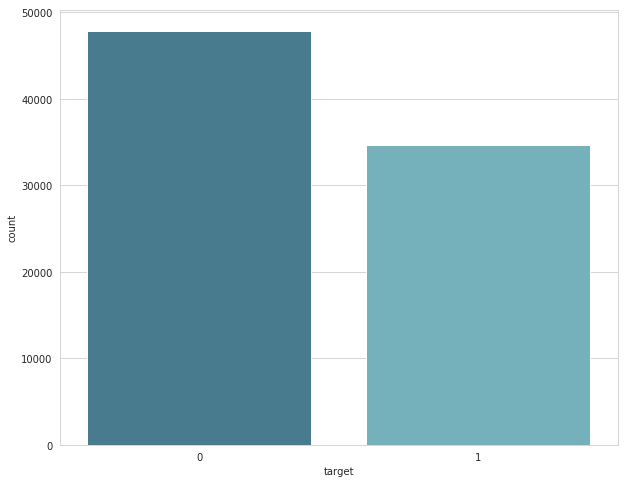

In [15]:
# visualize class balance
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.countplot(x='target',data=data_train, palette='GnBu_d')

In [0]:
# Undersample majority
sad_downsampled = resample(happy,
                                replace = False, # sample without replacement
                                n_samples = len(sad), # match minority n
                                random_state = 23) # reproducible results

In [0]:
# combine minority and downsampled majority
downsampled = pd.concat([sad, sad_downsampled])

In [18]:
# check counts
downsampled.target.value_counts()

1    34679
0    34679
Name: target, dtype: int64

In [0]:
# redefine X_train, y_train
X_train = downsampled.drop('target', axis=1)
y_train = downsampled.target

In [20]:
print('X_train', len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

X_train 69358
X_test 20642
y_train 69358
y_test 20642


## Scaling the Data

In [0]:
# instantiate the scaler, fit to train data and transform it
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)

In [0]:
#Use the scaler that is fit to the training data to transform the testing data
scaled_test = scaler.transform(X_test)

In [23]:
# turn scaled training dataset to pandas dataframe
scaled_train = pd.DataFrame(scaled_train, columns=X_train.columns)
scaled_train.head()

,likes_count,replies_count,retweets_count,tweet_ss,num_hashtags,avg_convo_ss,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_tag_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_depression,search_happiness,search_happy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,autumn,spring,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,PM
0,-0.063439,-0.063309,-0.069375,0.579435,0.920042,0.580318,-0.469746,0.580447,1.376670,0.533013,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,0.116672,-0.500488,-0.611537,1.059985,0.966728,-0.559300,0.458559,-0.581959,0.206317,-0.566804,0.205661,0.618709,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.307360,-0.305163,-0.313858,-0.314666,1.026635,-0.310497,-1.376670
1,-0.042042,0.058221,-0.055103,-1.556802,-0.529032,-1.559524,-0.747734,-1.520728,1.376670,-1.273893,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,2.803673,-0.500488,-0.611537,-0.912334,-0.567781,-0.559300,-0.454016,-0.581959,-0.566823,3.325594,-0.552985,-1.405645,3.085133,-0.308144,-0.29904,-0.321322,-0.299048,5.365339,-0.307360,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497,-1.376670
2,-0.062361,-0.060460,-0.070105,-0.533726,-0.161103,-0.534722,-0.037971,-1.045963,-0.213400,-0.481543,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,1.120649,-0.086873,1.690466,-0.090199,-0.08304,-0.086982,0.704454,-0.500488,0.174673,-0.912334,-0.088247,0.427638,0.116344,-0.142889,0.399602,-0.080255,0.869476,-1.089339,-0.108412,0.481886,-0.29904,0.449442,-0.299048,0.378193,-0.307360,-0.305163,0.464497,1.256376,-0.300668,1.272246,0.213400
3,-0.063544,-0.057965,-0.071209,0.270110,-0.527391,0.277962,-0.273497,1.100994,0.466622,0.977957,11.440568,-0.008235,-0.003797,-0.132375,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,-0.548440,-0.500488,-0.599107,1.533576,0.175213,-0.036574,0.005879,-0.269577,-0.062602,0.017825,-0.545488,1.109794,-0.550207,-0.308144,-0.29904,-0.321322,-0.299048,-0.322993,-0.294837,-0.305163,-0.301552,-0.314666,-0.300668,-0.310497,-0.466622
4,-0.063485,-0.063309,-0.071321,-2.588290,-0.529032,-2.592753,0.052293,-0.223959,0.104614,-1.735881,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,1.124298,1.331062,-0.611537,-0.912334,-0.567781,1.414577,1.827421,-0.581959,-0.566823,-0.566804,1.343630,-0.140424,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.307360,-0.305163,2.799561,-0.314666,-0.300668,-0.310497,-0.104614


In [24]:
scaled_train.shape

(69358, 52)

In [25]:
# turn scaled testing dataset to pandas dataframe
scaled_test = pd.DataFrame(scaled_test, columns=X_test.columns)
scaled_test.head()

,likes_count,replies_count,retweets_count,tweet_ss,num_hashtags,avg_convo_ss,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_tag_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_depression,search_happiness,search_happy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,autumn,spring,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,PM
0,0.083635,0.165940,0.078921,0.036103,-0.529032,0.072359,0.089969,-0.337856,-0.011027,-0.772313,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,1.497567,-0.039748,-0.239953,-0.567781,0.517360,-0.039209,0.056688,-0.566823,0.848613,0.826371,-0.255444,0.098961,-0.308144,-0.29904,0.239234,0.302628,0.183888,-0.30736,0.278223,0.818294,0.256622,0.302651,-0.310497,0.011027
1,-0.058441,-0.051440,-0.062199,0.646516,-0.279029,0.647513,0.569359,1.116718,1.376670,0.984739,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.500488,-0.611537,1.553065,-0.088247,-0.065831,0.971882,0.296181,-0.325217,-0.323529,-0.552985,1.124797,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497,-1.376670
2,0.048108,0.103795,-0.037263,0.391871,-0.529032,0.392438,2.785987,-1.520728,1.376670,0.868778,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.500488,2.533303,-0.912334,-0.567781,-0.559300,-0.454016,2.930600,-0.566823,-0.566804,-0.552985,-1.405645,3.085133,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,6.112082,-0.313858,-0.314666,-0.300668,-0.310497,-1.376670
3,-0.055646,-0.055713,-0.064834,1.169928,0.678530,1.171808,2.785987,1.116718,-1.167441,0.984739,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.500488,-0.611537,1.553065,-0.567781,-0.559300,-0.454016,2.930600,-0.566823,-0.566804,-0.552985,1.124797,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497,1.167441
4,-0.058268,-0.057612,-0.054697,-1.145983,2.706856,-1.148012,-0.729156,-1.045963,0.104614,-1.807817,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,2.731197,2.514404,-0.555078,2.246838,-0.611537,-0.912334,-0.567781,0.427638,-0.454016,-0.581959,-0.083611,0.892845,0.869476,-1.089339,-0.108412,1.271916,-0.29904,-0.321322,0.528257,0.378193,-0.30736,-0.305163,0.464497,1.256376,-0.300668,0.480875,-0.104614


In [26]:
scaled_test.shape

(20642, 52)

# Base Models

## Naive Bayes

In [0]:
# create a Naive Bayes instance and assign to variable
clf = GaussianNB()

In [0]:
# fit Naive Bayes instance to training data and assign to variable
nb_base = clf.fit(scaled_train, y_train)

In [34]:
nb_base

GaussianNB(priors=None, var_smoothing=1e-09)

In [35]:
# create a classification report for the model on training data
nb_preds_train = nb_base.predict(scaled_train)
print(classification_report(y_train, nb_preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34679
           1       1.00      1.00      1.00     34679

    accuracy                           1.00     69358
   macro avg       1.00      1.00      1.00     69358
weighted avg       1.00      1.00      1.00     69358



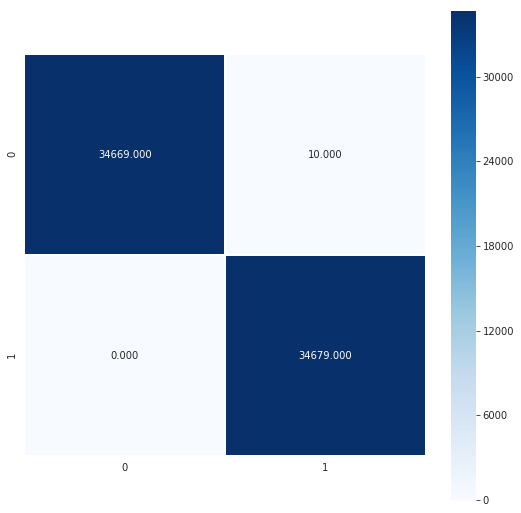

In [36]:
#confusion matrix visualization of train data
cm_nb_train = confusion_matrix(y_train, nb_preds_train)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_nb_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [37]:
# create a classification report for the model on testing data
nb_preds_test = nb_base.predict(scaled_test)
print(classification_report(y_test, nb_preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11906
           1       1.00      1.00      1.00      8736

    accuracy                           1.00     20642
   macro avg       1.00      1.00      1.00     20642
weighted avg       1.00      1.00      1.00     20642



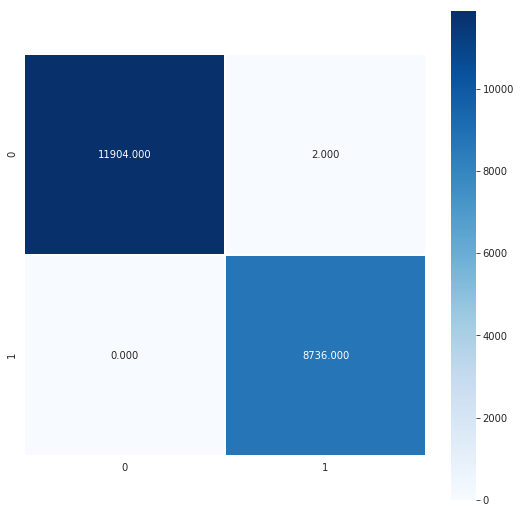

In [38]:
#confusion matrix visualization of train data
cm_nb_test = confusion_matrix(y_test, nb_preds_test)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_nb_test, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [0]:
# # pickle base model
# pickle_model(nb_base, nb_base)

## Support Vector Machine

In [0]:
# create a Support Vector Machine instance for linear SVM
svm = SVC(kernel='linear')

In [0]:
# fit SVM to training data
svm_base = svm.fit(scaled_train, y_train)

In [43]:
# create a classification report for the model on training data
svm_preds_train = svm_base.predict(scaled_train)
print(classification_report(y_train, svm_preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34679
           1       1.00      1.00      1.00     34679

    accuracy                           1.00     69358
   macro avg       1.00      1.00      1.00     69358
weighted avg       1.00      1.00      1.00     69358



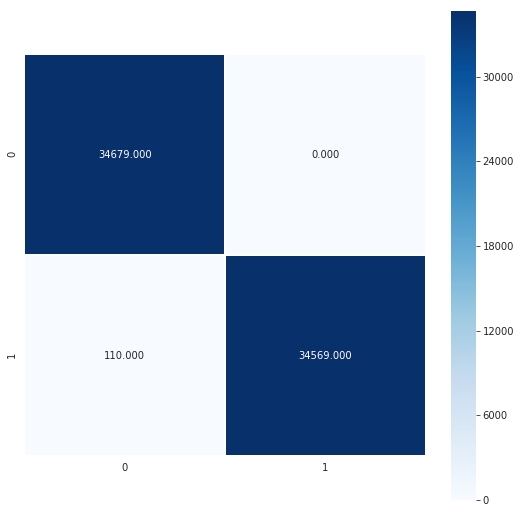

In [44]:
#confusion matrix visualization of train data
cm_svm_train = confusion_matrix(y_train, svm_preds_train)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_svm_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [45]:
# create a classification report for the model on testing data
svm_preds_test = svm_base.predict(scaled_test)
print(classification_report(y_test, svm_preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11906
           1       1.00      1.00      1.00      8736

    accuracy                           1.00     20642
   macro avg       1.00      1.00      1.00     20642
weighted avg       1.00      1.00      1.00     20642



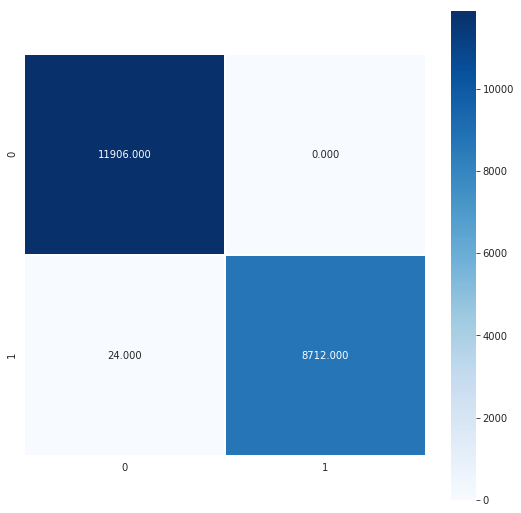

In [46]:
#confusion matrix visualization of train data
cm_svm_test = confusion_matrix(y_test, svm_preds_test)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_svm_test, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [141]:
# Model Accuracy, how often is the classifier correct?
print('Training F1 Score:', f1_score(y_train, svm_preds_train))
print('Testing F1 Score:', f1_score(y_test, svm_preds_test))

Training F1 Score: 0.9984115064695009
Testing F1 Score: 0.9986244841815681


In [0]:
# # pickle base model
# pickle_model(svm_base, svm_base)

# Feature Selection

## Read In Updated Dataset After Dropping Highly Correlated Features

In [0]:
# read in updated dataset from EDA notebook after dropping highly correlated features
data2 = pd.read_pickle('corr_user_df.pkl')

# Data Preparation

In [0]:
# identify features
features = data2.drop('user_id', axis=1).copy()

In [0]:
# identify X and y
X = features.drop('target', axis=1)
y = features.target

In [0]:
# create training and testing datasets with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [52]:
print('X_train', len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

X_train 82567
X_test 20642
y_train 82567
y_test 20642


## Class Imbalance

In [0]:
# Concat X_train, y_train together into a training dataset
data_train2 = pd.concat([X_train, y_train], axis=1)

In [0]:
# Separate minority and majority classes
happy = data_train2[data_train2.target == 0]
sad = data_train2[data_train2.target == 1]

In [55]:
print('# of Happy Users: '+ str(len(happy)))
print('# of Sad Users: '+ str(len(sad)))

# of Happy Users: 47888
# of Sad Users: 34679


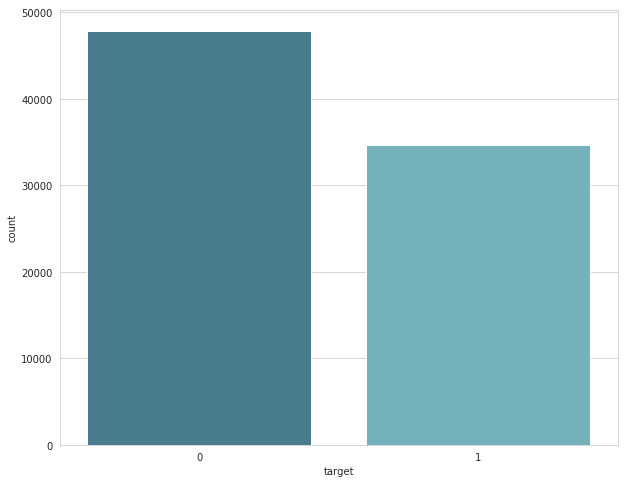

In [56]:
# visualize class balance
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.countplot(x='target',data=data_train2, palette='GnBu_d')

In [0]:
# Undersample majority
sad_downsampled = resample(happy,
                                replace = False, # sample without replacement
                                n_samples = len(sad), # match minority n
                                random_state = 23) # reproducible results

In [0]:
# combine minority and downsampled majority
downsampled = pd.concat([sad, sad_downsampled])

In [59]:
# check counts
downsampled.target.value_counts()

1    34679
0    34679
Name: target, dtype: int64

In [0]:
# redefine X_train, y_train
X_train = downsampled.drop('target', axis=1)
y_train = downsampled.target

In [61]:
print('X_train', len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

X_train 69358
X_test 20642
y_train 69358
y_test 20642


## Scaling the Data

In [0]:
# instantiate the scaler, fit to train data and transform it
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)

In [0]:
#Use the scaler that is fit to the training data to transform the testing data
scaled_test = scaler.transform(X_test)

In [64]:
# turn scaled training dataset to pandas dataframe
scaled_train = pd.DataFrame(scaled_train, columns=X_train.columns)
scaled_train.head()

,likes_count,tweet_ss,num_hashtags,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_happiness,Friday,Monday,Saturday,Thursday,Tuesday,autumn,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,-0.063439,0.579435,0.920042,-0.469746,0.580447,1.376670,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,0.116672,-0.611537,0.966728,-0.559300,0.458559,0.206317,-0.566804,0.205661,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.307360,-0.305163,-0.313858,-0.314666,1.026635,-0.310497
1,-0.042042,-1.556802,-0.529032,-0.747734,-1.520728,1.376670,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,2.803673,-0.611537,-0.567781,-0.559300,-0.454016,-0.566823,3.325594,-0.552985,3.085133,-0.308144,-0.29904,-0.321322,-0.299048,5.365339,-0.307360,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497
2,-0.062361,-0.533726,-0.161103,-0.037971,-1.045963,-0.213400,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,1.120649,-0.086873,1.690466,-0.090199,-0.08304,-0.086982,0.704454,0.174673,-0.088247,0.427638,0.116344,0.399602,-0.080255,0.869476,-0.108412,0.481886,-0.29904,0.449442,-0.299048,0.378193,-0.307360,-0.305163,0.464497,1.256376,-0.300668,1.272246
3,-0.063544,0.270110,-0.527391,-0.273497,1.100994,0.466622,11.440568,-0.008235,-0.003797,-0.132375,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,-0.548440,-0.599107,0.175213,-0.036574,0.005879,-0.062602,0.017825,-0.545488,-0.550207,-0.308144,-0.29904,-0.321322,-0.299048,-0.322993,-0.294837,-0.305163,-0.301552,-0.314666,-0.300668,-0.310497
4,-0.063485,-2.588290,-0.529032,0.052293,-0.223959,0.104614,0.000000,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.08304,-0.086982,1.124298,-0.611537,-0.567781,1.414577,1.827421,-0.566823,-0.566804,1.343630,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.307360,-0.305163,2.799561,-0.314666,-0.300668,-0.310497


In [65]:
scaled_train.shape

(69358, 43)

In [66]:
# turn scaled testing dataset to pandas dataframe
scaled_test = pd.DataFrame(scaled_test, columns=X_test.columns)
scaled_test.head()

,likes_count,tweet_ss,num_hashtags,avg_day_ss,avg_season_ss,avg_time_of_day_ss,avg_pop_ss,hashtag_anxiety,hashtag_depression,hashtag_friends,hashtag_fun,hashtag_happiness,hashtag_happy,hashtag_hope,hashtag_lonely,hashtag_love,hashtag_pain,hashtag_peace,hashtag_ptsd,hashtag_sad,hashtag_smile,hashtag_stress,hashtag_suicide,search_anxiety,search_happiness,Friday,Monday,Saturday,Thursday,Tuesday,autumn,summer,Month_1,Month_2,Month_3,Month_4,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0.083635,0.036103,-0.529032,0.089969,-0.337856,-0.011027,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.039748,-0.567781,0.517360,-0.039209,-0.566823,0.848613,0.826371,0.098961,-0.308144,-0.29904,0.239234,0.302628,0.183888,-0.30736,0.278223,0.818294,0.256622,0.302651,-0.310497
1,-0.058441,0.646516,-0.279029,0.569359,1.116718,1.376670,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.611537,-0.088247,-0.065831,0.971882,-0.325217,-0.323529,-0.552985,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497
2,0.048108,0.391871,-0.529032,2.785987,-1.520728,1.376670,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,2.533303,-0.567781,-0.559300,-0.454016,-0.566823,-0.566804,-0.552985,3.085133,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,6.112082,-0.313858,-0.314666,-0.300668,-0.310497
3,-0.055646,1.169928,0.678530,2.785987,1.116718,-1.167441,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,-0.083040,-0.086982,-0.555078,-0.611537,-0.567781,-0.559300,-0.454016,-0.566823,-0.566804,-0.552985,-0.564633,-0.308144,-0.29904,-0.321322,-0.299048,-0.334257,-0.30736,-0.305163,-0.313858,-0.314666,-0.300668,-0.310497
4,-0.058268,-1.145983,2.706856,-0.729156,-1.045963,0.104614,0.0,-0.008235,-0.003797,-0.153476,-0.151189,-0.016955,-0.119757,-0.103549,-0.023753,-0.251389,-0.054021,-0.141428,-0.086873,-0.104889,-0.090199,2.731197,2.514404,-0.555078,-0.611537,-0.567781,0.427638,-0.454016,-0.083611,0.892845,0.869476,-0.108412,1.271916,-0.29904,-0.321322,0.528257,0.378193,-0.30736,-0.305163,0.464497,1.256376,-0.300668,0.480875


In [67]:
scaled_test.shape

(20642, 43)

## Decision Tree Feature Importance

In [0]:
# Create an instance of DecisionTreeClassifier() called dtree
dtree = DecisionTreeClassifier()

In [0]:
# fit Decision Tree Classifier object to training data
dtree_select = dtree.fit(X_train, y_train)

In [0]:
# Calculate feature importances and put in dataframe
feat_importances = pd.DataFrame(zip(X_train.columns, dtree_select.feature_importances_), columns=['Feature','Feature Importance'])

In [0]:
# sort feature importances based on value
feat_importances = feat_importances.sort_values('Feature Importance', ascending=False).reset_index(drop=True)

In [111]:
feat_importances.tail()

,Feature,Feature Importance
38,hashtag_lonely,0.000358
39,hashtag_happiness,0.000183
40,avg_pop_ss,0.000000
41,hashtag_anxiety,0.000000
42,hashtag_depression,0.000000


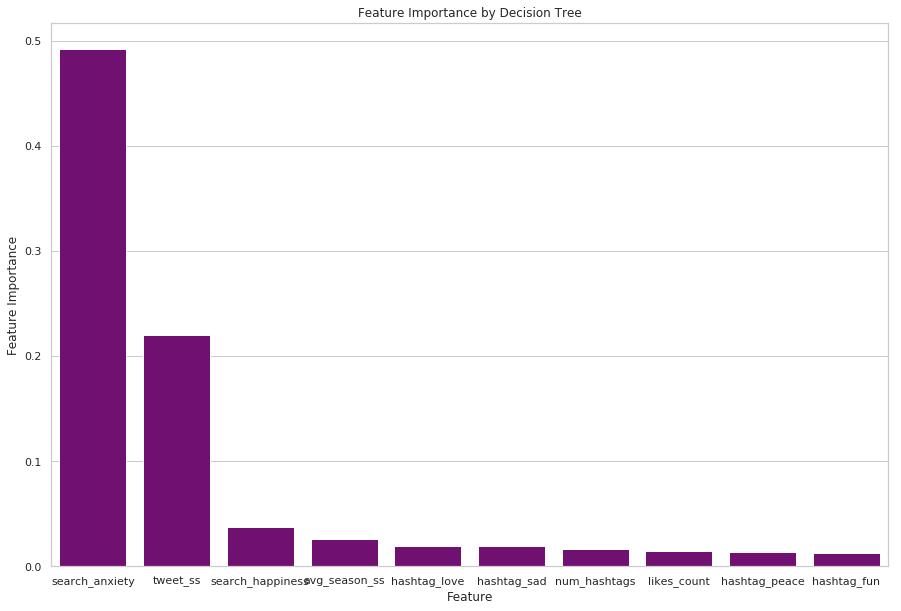

In [110]:
# plot feature importances
sns.set(style="whitegrid")
plt.figure(figsize=(15,10))
plt.title('Feature Importance by Decision Tree')
sns.barplot(feat_importances['Feature'][:10], feat_importances['Feature Importance'][:10], color='purple')

In [0]:
# remove features considered not very important per feature importance by Decision Tree
data2.drop(['hashtag_lonely', 'hashtag_happiness', 'avg_pop_ss', 'hashtag_anxiety', 'hashtag_depression'], axis=1, inplace=True)

# Rerun Models

## Naive Bayes

In [0]:
# create a Naive Bayes instance and assign to variable
clf2 = GaussianNB()

In [0]:
# fit Naive Bayes instance to training data and assign to variable
nb_rerun = clf2.fit(scaled_train, y_train)

In [115]:
nb_rerun

GaussianNB(priors=None, var_smoothing=1e-09)

In [116]:
# create a classification report for the model on training data
nb_preds_train2 = nb_rerun.predict(scaled_train)
print(classification_report(y_train, nb_preds_train2))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     34679
           1       1.00      0.73      0.84     34679

    accuracy                           0.86     69358
   macro avg       0.89      0.86      0.86     69358
weighted avg       0.89      0.86      0.86     69358



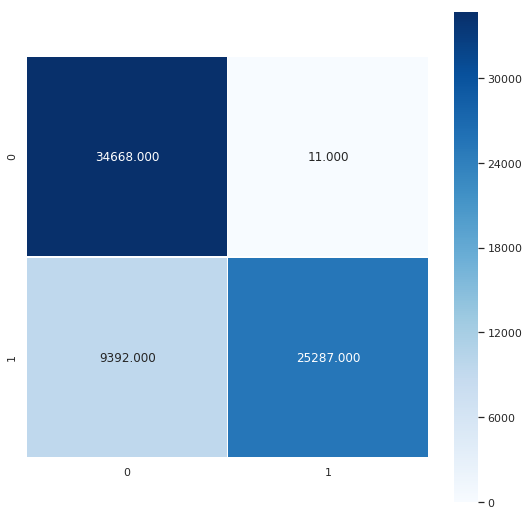

In [117]:
#confusion matrix visualization of train data
cm_nb_train2 = confusion_matrix(y_train, nb_preds_train2)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_nb_train2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [119]:
# create a classification report for the model on testing data
nb_preds_test2 = nb_rerun.predict(scaled_test)
print(classification_report(y_test, nb_preds_test2))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     11906
           1       1.00      0.73      0.84      8736

    accuracy                           0.89     20642
   macro avg       0.92      0.86      0.88     20642
weighted avg       0.90      0.89      0.88     20642



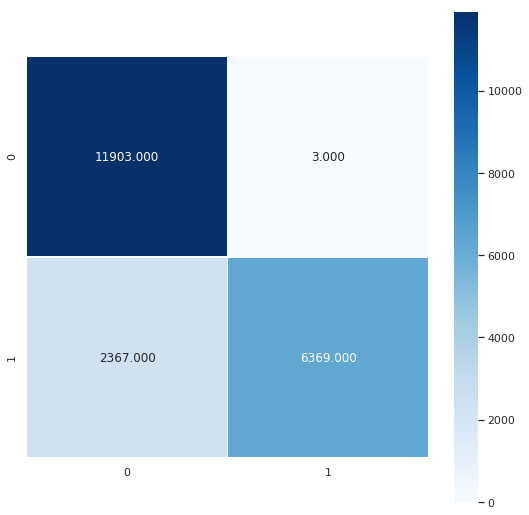

In [120]:
#confusion matrix visualization of train data
cm_nb_test2 = confusion_matrix(y_test, nb_preds_test2)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_nb_test2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [140]:
# Model Accuracy, how often is the classifier correct?
print('Training F1 Score:', f1_score(y_train, nb_preds_train2))
print('Testing F1 Score:', f1_score(y_test, nb_preds_test2))

Training F1 Score: 0.8432232355736367
Testing F1 Score: 0.8431294678316124


In [0]:
# # pickle rerun model
# pickle_model(nb_rerun, nb_rerun)

## Support Vector Machine

In [0]:
# create a Support Vector Machine instance for linear SVM
svm2 = SVC(kernel='linear')

In [0]:
# fit SVM to training data
svm_rerun = svm2.fit(scaled_train, y_train)

In [124]:
# create a classification report for the model on training data
svm_preds_train2 = svm_rerun.predict(scaled_train)
print(classification_report(y_train, svm_preds_train2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     34679
           1       0.98      0.93      0.96     34679

    accuracy                           0.96     69358
   macro avg       0.96      0.96      0.96     69358
weighted avg       0.96      0.96      0.96     69358



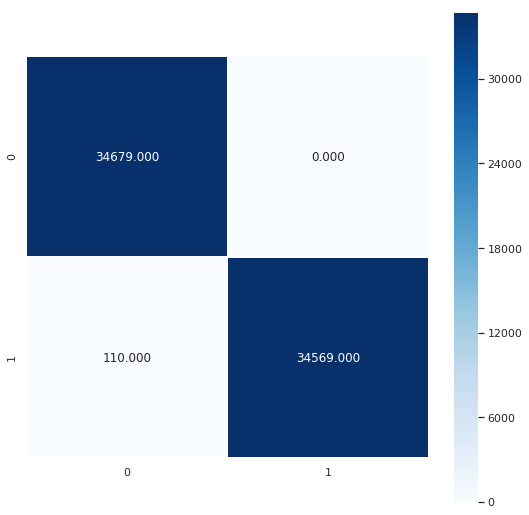

In [125]:
#confusion matrix visualization of train data
cm_svm_train2 = confusion_matrix(y_train, svm_preds_train)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_svm_train2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [126]:
# create a classification report for the model on testing data
svm_preds_test2 = svm_rerun.predict(scaled_test)
print(classification_report(y_test, svm_preds_test2))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11906
           1       0.97      0.93      0.95      8736

    accuracy                           0.96     20642
   macro avg       0.96      0.96      0.96     20642
weighted avg       0.96      0.96      0.96     20642



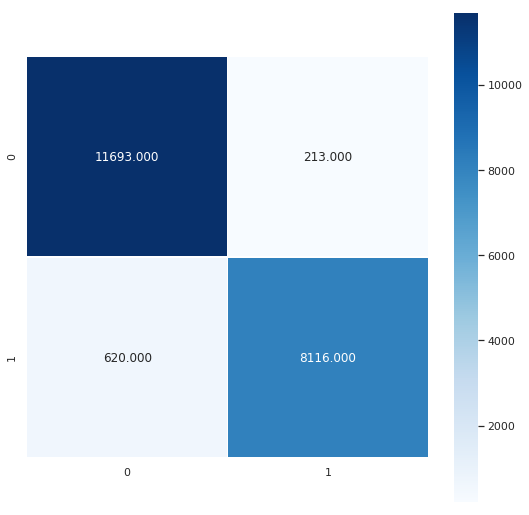

In [127]:
#confusion matrix visualization of train data
cm_svm_test2 = confusion_matrix(y_test, svm_preds_test2)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_svm_test2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = plt.cm.Blues)

In [139]:
# Model Accuracy, how often is the classifier correct?
print('Training F1 Score:', f1_score(y_train, svm_preds_train2))
print('Testing F1 Score:', f1_score(y_test, svm_preds_test2))

Training F1 Score: 0.9562956177417925
Testing F1 Score: 0.9511866393202462


In [0]:
# # pickle rerun model
# pickle_model(svm_rerun, svm_rerun)

# Randomized Search

## Support Vector Machines

In [0]:
# instantiate SVM classifier
svc = SVC(random_state=34)

In [0]:
param_distributions = { 
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.001, 0.0001],
    'probability': [True, False] 
}

In [0]:
# Use randomizedsearch with our pipeline to find best parameters
rs_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, cv= 3, n_jobs=-1, verbose=5)

In [0]:
# fit Randomized Search model to training data
svm_rs = rs_svc.fit(X_train, y_train)

In [0]:
# view best parameters
svm_rs.best_params_

In [0]:
# predict on train set
svm_rs_pred_train = svm_rs.best_estimator_.predict(scaled_train)

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_train, svm_rs_pred_train))

# checking accuracy
print('Train F1 score: ', f1_score(y_train, svm_rs_pred_train))

In [0]:
# predict on test set
svm_rs_pred_test = svm_rs.best_estimator_.predict(scaled_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, svm_rs_pred_test))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, svm_rs_pred_test))

In [0]:
# pickle rerun model
pickle_model(svm_rs, svm_rs)

# Final Models